In [29]:
%pip install numpy pandas seaborn matplotlib scipy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from scipy.stats import lognorm

run_time_seconds = 30
folders = ["K6M2-0-20", "K6M2-100-20", "K6M2-256-20", "K6M2-320-20", "K6M2-640-20", "K6M2-1024-20"]
K=6.
M=2.

In [31]:
stats_files = []
results_folders = [f".results/{folder}/.results/" for folder in folders]
for folder in results_folders:
    if os.path.exists(folder):
        match = re.search(r"(K\d+M\d+)-(\d+)-\w+", folder)
        if not match:
            raise Exception(f"Invalid folder: {folder}")
        # Extracting cluster and fec_threshold
        cluster = match.group(1)
        fec_threshold = int(match.group(2))
        
        for file in os.listdir(folder):
            if file.endswith('_stats.csv'):
                match = re.search(r"results_(\d+)_(\d+)_stats\.csv", file)
                if not match:
                    raise Exception(f"Invalid filename: {file}")
                # Extracting payload_size and num_users
                payload_size = int(match.group(1))
                num_users = int(match.group(2))

                full_path = os.path.join(folder, file)
                stats_files.append(
                    {"csv_filename": full_path, 
                     "cluster": cluster, 
                     "fec_threshold": fec_threshold, 
                     "payload_size": payload_size, 
                     "num_users": num_users})


results = []
for stats_file in stats_files:
    df = pd.read_csv(stats_file["csv_filename"])
    if not df.empty:
        agg_row = df.iloc[-1]  # Select the last row
        if agg_row["Name"] == "Aggregated":
            results.append({
                "payload_size": int(stats_file["payload_size"]),
                "num_users": int(stats_file["num_users"]),
                "fec_threshold": int(stats_file["fec_threshold"]),
                "total_requests": int(agg_row["Request Count"]),
                "avg_response_time": float(agg_row["Average Response Time"]),
                "med_response_time": float(agg_row["Median Response Time"]),
            })
        else:
            print(f"No aggregated data found in {stats_file['csv_filename']}")
    else:
        print(f"The CSV file is empty: {stats_file['csv_filename']}")

results_df = pd.DataFrame(results)
pd.set_option('display.max_rows', None)
print(results_df)
pd.reset_option('display.max_rows')


     payload_size  num_users  fec_threshold  total_requests  \
0           28184         20              0            9995   
1            8442         20              0           10528   
2             124         20              0           10855   
3           15425         20              0           10265   
4          314101         20              0            6880   
5              11         20              0           10859   
6              20         20              0           10902   
7            2528         20              0           10681   
8              67         20              0           10806   
9               1         20              0           10851   
10            414         20              0           10819   
11              6         20              0           10790   
12              3         20              0           10865   
13            226         20              0           10865   
14         171911         20              0            

In [32]:
print( results_df['num_users'])

0      20
1      20
2      20
3      20
4      20
       ..
134    20
135    20
136    20
137    20
138    20
Name: num_users, Length: 139, dtype: int64


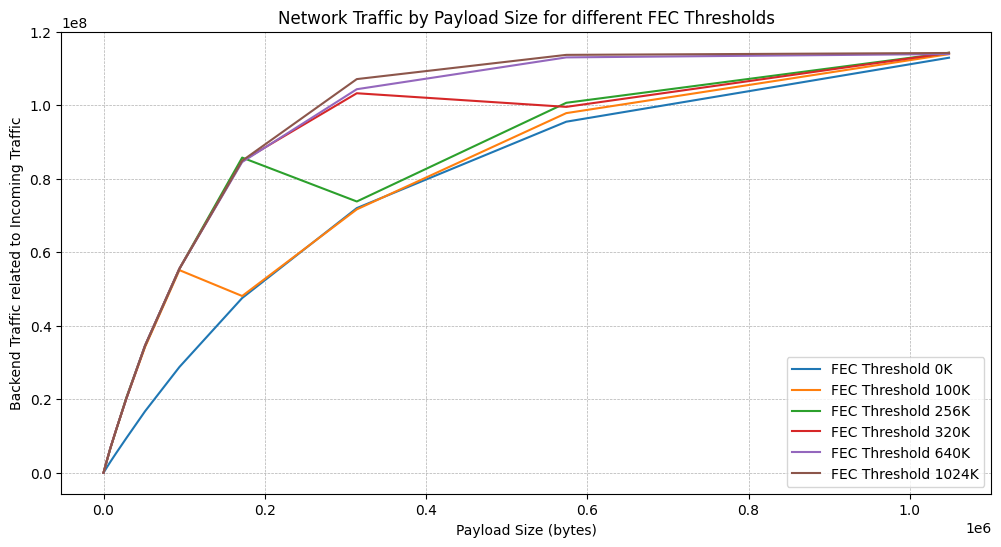

In [38]:
results_df['traffic'] = results_df['total_requests'] / run_time_seconds * results_df['payload_size']

# Group by 'fec_threshold' and 'payload_size' and calculate the mean 'total_requests'
grouped = results_df.groupby(['fec_threshold', 'payload_size']).mean()['traffic'].unstack(0)

# Create a twin axis to plot outgoing traffic
fig, ax1 = plt.subplots(figsize=(12, 6))

for fec_threshold in grouped.columns:
    plt.plot(grouped[fec_threshold], label=f"FEC Threshold {fec_threshold}K")


plt.xlabel('Payload Size (bytes)')
plt.ylabel('Backend Traffic related to Incoming Traffic')
plt.title('Network Traffic by Payload Size for different FEC Thresholds')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
#plt.xscale('log', base=2)
plt.show()

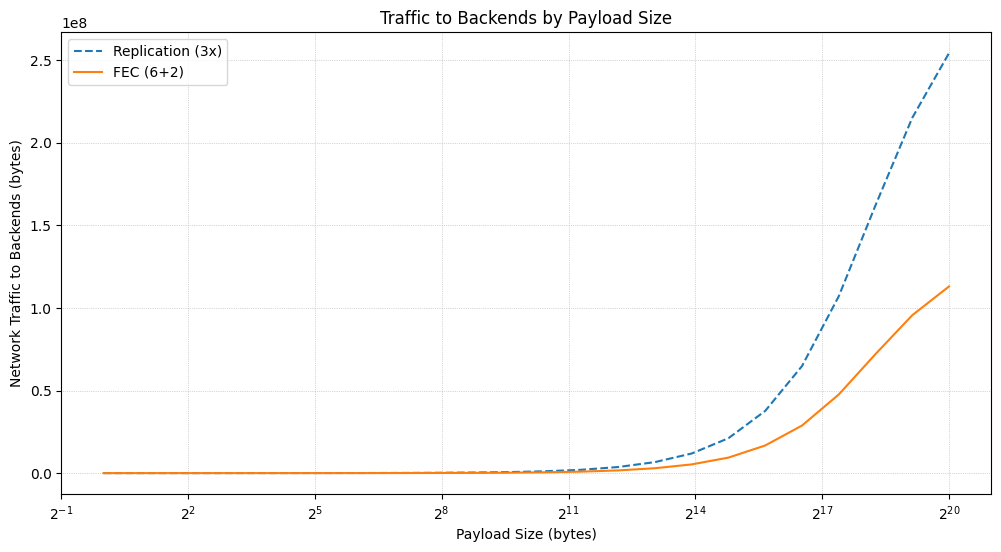

In [64]:
# Constants given
mode = 10 * 1024  # mode of the log-normal distribution
mean = 30 * 1024  # mean of the log-normal distribution

# Calculate mu and sigma
mu = np.log(mode)
sigma = np.sqrt(2 * (np.log(mean) - mu))

# Define the log-normal distribution
distribution = lognorm(s=sigma, scale=np.exp(mu))

# Assuming 'results_df' is your DataFrame
# Calculate the PDF of the log-normal distribution for each 'payload_size'
results_df['weight'] = distribution.pdf(results_df['payload_size'])


results_df['replication_outgoing_traffic'] = results_df['traffic'] * (K / (K + M)) * (M + 1) 
results_df['delta_traffic'] = results_df['replication_outgoing_traffic'] - results_df['traffic']

fec_threshold_0_df = results_df[results_df['fec_threshold'] == 0]


grouped_traffic = fec_threshold_0_df.groupby('payload_size').mean()['traffic']
grouped_replication_outgoing_traffic = fec_threshold_0_df.groupby('payload_size').mean()['replication_outgoing_traffic']
grouped_delta_traffic = fec_threshold_0_df.groupby('payload_size').mean()['delta_traffic']

#grouped_weighted_traffic = results_df.groupby(['fec_threshold', 'payload_size']).mean()['weighted_traffic'].unstack(0)
#grouped_weighted_replication_outgoing_traffic = results_df[results_df['fec_threshold'] == 0].groupby('payload_size').mean()['weighted_replication_outgoing_traffic']

# Create a twin axis to plot outgoing traffic
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot weighted traffic for different FEC thresholds
#for fec_threshold in grouped_weighted_traffic.columns:
#    ax1.plot(grouped_weighted_traffic[fec_threshold], label=f"FEC Threshold {fec_threshold}")

# Plot weighted replication_outgoing_traffic
#ax1.plot(grouped_weighted_replication_outgoing_traffic, label='Replication', linestyle='--')
# Plot fec_outgoing_traffic and replication_outgoing_traffic

ax1.plot(grouped_replication_outgoing_traffic, label='Replication (3x)', linestyle='--')
#ax1.plot(grouped_delta_traffic, label='Delta', linestyle='--')
ax1.plot(grouped_traffic, label='FEC (6+2)')

#ax1.plot(results_df.groupby('payload_size').mean()['weight'], label='Weight', linestyle='--')

ax1.set_xlabel('Payload Size (bytes)')
ax1.set_ylabel('Network Traffic to Backends (bytes)')
ax1.set_title('Traffic to Backends by Payload Size')
ax1.legend()
ax1.grid(True, linestyle=':', linewidth=0.5)
ax1.set_xscale('log', base=2)

plt.show()
